### Implement BEAM + 2-Box Temperature Model

- Drive with imposed CO$_2$ ppm
- OR, drive with Emissions

In [ ]:
#First load some libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from scipy import interpolate

C:\Users\steff\Anaconda3\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


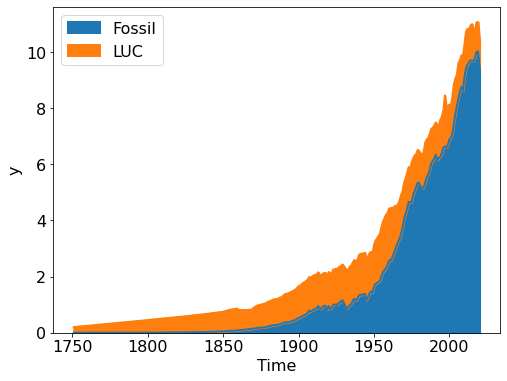

In [ ]:
## Get the Emissions Data and Visualize
#############################

#global K_H K_1 K_2 delta_d delta_a AM Alk k_a k_d E_course
fname = r'Data/Global_Carbon_Budget_2021v1.0.xlsx'

df = pd.read_excel(fname, sheet_name = "Historical Budget", header = 16,
                                 names = ['Year', 'Fossil', 'LUC', 'Atm_Growth', 'Ocean_Sink', 'Land_Sink', 'Cement_Carb_Sink', 'Imbalance']);

#Do a linear interpolation from 0.2 to value at 1850 for LUC:
df.LUC.iloc[0:99] = np.interp(df.Year[0:99], [1751, 1849], [0.2, df.LUC[99]])

fig, ax1 = plt.subplots(1, 1, figsize=(8,6))

fs = 16
#ax1.plot(df.Year, df.Fossil + df.LUC, linewidth=2)

df.plot.area('Year', ['Fossil', 'LUC'], linewidth=2, ax=ax1)

ax1.set_xlabel('Time', fontsize = fs);
ax1.set_ylabel('y', fontsize = fs);
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.legend(fontsize=fs);


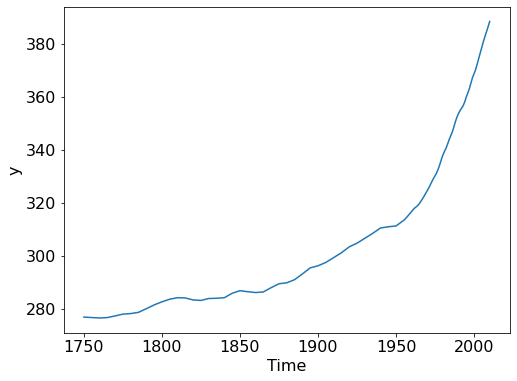

In [ ]:
#Now get the CO2 ppm, and other Kyoto data ppm:

fname = r'Data/WG1AR5_AIISM_Datafiles.xlsx'

df_conc_base = pd.read_excel(fname, sheet_name = "AII-1-1a", header = 8, nrows=97, index_col=None, usecols=[0,1,2,3],
                                 names = ['Year', 'CO2', 'CH4', 'N2O']);

fig, ax1 = plt.subplots(1, 1, figsize=(8,6))

fs = 16
ax1.plot(df_conc_base.Year, df_conc_base.CO2)

ax1.set_xlabel('Time', fontsize = fs);
ax1.set_ylabel('y', fontsize = fs);
ax1.tick_params(axis='both', which='major', labelsize=fs)


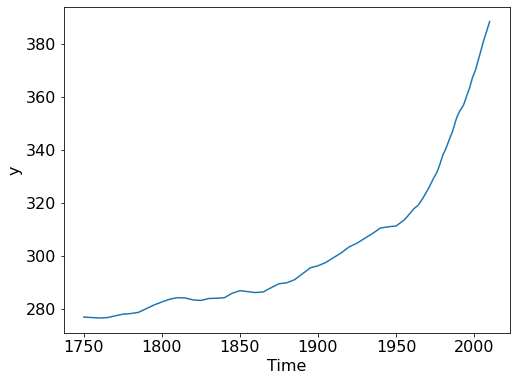

In [ ]:
#Do a linear interpolation onto 1750 through 2010
####

df_conc = pd.DataFrame(columns=['Year', 'CO2', 'CH4', 'N2O'])

for k in df_conc_base.columns:
    df_conc[k] =  np.interp(np.arange(1750,2011), df_conc_base.Year, df_conc_base[k])
    

fig, ax1 = plt.subplots(1, 1, figsize=(8,6))

fs = 16
ax1.plot(df_conc.Year, df_conc.CO2)

ax1.set_xlabel('Time', fontsize = fs);
ax1.set_ylabel('y', fontsize = fs);
ax1.tick_params(axis='both', which='major', labelsize=fs)


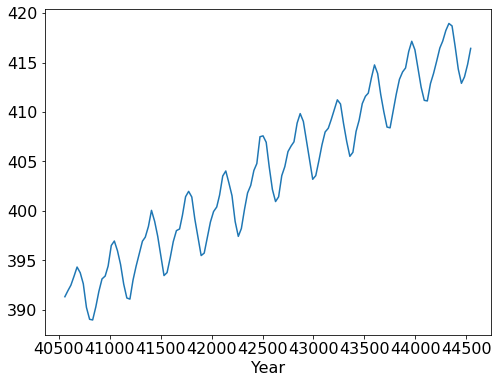

In [ ]:
#Also get CO2 averaged for years 2011 - 2021 from Keeling Data

fname = r'Data/monthly_in_situ_co2_mlo.csv'

df_conc_mlo = pd.read_csv(fname, header = 692, nrows = 11*12, usecols=[0,1,2,3,4],
                                 names = ['Year', 'Mn', 'Date1', 'Date2', 'CO2'])

fig, ax1 = plt.subplots(1, 1, figsize=(8,6))

fs = 16
ax1.plot(df_conc_mlo.Date1, df_conc_mlo.CO2)

ax1.set_xlabel('Year', fontsize = fs);
ax1.tick_params(axis='both', which='major', labelsize=fs)

In [ ]:
#Now group by year and take the mean:
df_conc_mlo_year = df_conc_mlo.groupby('Year').mean()

df_conc_mlo_year = df_conc_mlo_year.reset_index()

df_conc_mlo_year = df_conc_mlo_year[['Year', 'CO2']]

df_conc_mlo_year['CH4'] = np.nan
df_conc_mlo_year['N2O'] = np.nan

#df_conc_mlo_year.Year = df_conc_mlo_year.Year.astype(float)

In [ ]:
#Concatenate the additional years
df_conc = pd.concat([df_conc, df_conc_mlo_year], ignore_index=True)

In [ ]:
#Define our model parameters here (could also have as args to ode, but this is fine for now)
#Parameters
K_H = 1.23e3
k_a = .2
k_d = .05

AM = 1.77e20
OM = 7.8e22
delta_d = 50

#Solve for delta_a, given AM, OM, and delta_d
M_upper = OM / (delta_d + 1)
delta_a = M_upper / AM

#DIC dissociation constants. Convert to mole fraction:
K_1 = 8e-7 *  18/1000
K_2 = 4.53e-10 * 18/1000

#And moles of alkalinity
Alk = 767e15 / 12


In [ ]:
#Define a variable H_track to track pH
#H_track in mole fraction
H_track = np.zeros(10000)

In [ ]:
#Define the BEAM + Temperature Model: Drive with Emissions or CO2 ppm: passed argument
def BEAM_sys(y, t, drive_co2 = False):
    
    #Unpack:
    Q_A, Q_U, Q_L, T_mix, T_deep = y
    
    
    #Get the nearest year
    t_yrs = int(np.floor(t));
    
    #And get the emissions for this year:
    Emit = Emissions[t_yrs];
    
    
    #If driven by atmospheric CO2, just override Q_A
    if (drive_co2):
        Q_A = Imposed_CO2[t_yrs]
    
    
    #Get pH first
    #Everything is in moles and mole fraction, so we are good:
    a = 1;
    b = K_1 * (1 - Q_U / Alk);
    c = K_1*K_2 * (1 - 2*Q_U / Alk);
    
    #Take H as positive root
    H = (-b + np.sqrt(b**2 - 4*a*c)) / (2*a);
    
    #Also track H
    H_track[t_yrs] = H
    
    
    #And now our Lambda factor:
    Lambda = 1 + K_1/H + K_1*K_2/H**2;
    
    
    #Temperature change stuff
    #########
    mu_mix = 3.154e8;
    mu_deep = 6.307e9;
    lambda1 = 1.2;
    gamma1 = 1.2;
    
    #Forcings in s, but time-step years
    #So W_factor
    W_factor = 3600*24*365;
    
    #pCO2 in ppm:
    pCO2 = Q_A / AM * 1e6;
    
    #Delta_N as k * ln(pCO2/C0): Fixed C0 at 276.8
    delta_N = 5.35 * np.log(pCO2/277);
    
    dT_mix = 1/mu_mix * (-lambda1 * W_factor * T_mix - gamma1 * W_factor * (T_mix - T_deep) + delta_N * W_factor);
    dT_deep = 1/mu_deep * gamma1 * W_factor * (T_mix - T_deep);

    
    dydt = [-k_a * Q_A + K_H*k_a/delta_a/Lambda * Q_U + Emit,
          k_a * Q_A - K_H*k_a/delta_a/Lambda * Q_U + k_d/delta_d * Q_L - k_d * Q_U,
          -k_d/delta_d * Q_L + k_d * Q_U,
          dT_mix,
          dT_deep];
    
    return dydt


In [ ]:
#Embed the Emissions:
#ALSO: Convert to moles!
Emissions = np.zeros([10000])
Emissions[df.Year] = (df.Fossil + df.LUC) * 1e15/12

In [ ]:
#Imposed atmospheric CO2: Convert from ppm to moles
Imposed_CO2 = np.zeros([10000])
Imposed_CO2[df_conc.Year.astype(int)] = df_conc.CO2 / 1e6 * AM

#Imposed_CO2[df_conc.Year.astype(int)] = 590  * 1e15 / 12

In [ ]:
#Define T, and run the system with odeint:
T = np.linspace(1750, 2021, 2021-1750+1)


#Initial conditions    
Y0 = np.array([590, 713, 35658, 0, 0]) * 1e15/12

impose_co2 = True
Y = odeint(BEAM_sys, Y0, T, args=(impose_co2,), hmax=.1)

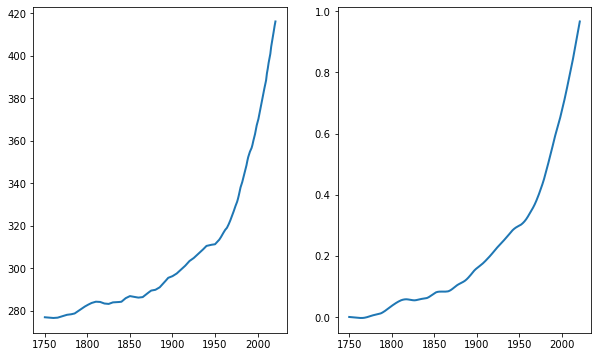

In [ ]:
#And Plot the results
########

fig, ax1 = plt.subplots(1, 2, figsize=(10,6))

fs = 16

#Plot as ppm:
if (impose_co2):
    ax1[0].plot(T, Imposed_CO2[T.astype(int)] / AM * 1e6, linewidth=2, label='Atm CO2 (ppm)')
else:
    ax1[0].plot(T, Y[:, 0] / AM * 1e6, linewidth=2, label='Atm CO2 (ppm)')


#And plot the upper ocean temperature perturbation:
ax1[1].plot(T, Y[:, 3], linewidth=2, label='Temp Perturbation')


#ax1[0].set_xlabel('Year', fontsize = fs);
#ax1[0].tick_params(axis='both', which='major', labelsize=fs)

In [ ]:
np.sum(Imposed_CO2[int(np.max(T))] - Imposed_CO2[int(np.min(T))]) / 1e15 * 12

295.8188326799998

In [ ]:
np.sum(Emissions) * 12 / 1e15

708.9470330644148

In [ ]:
(Y[len(Y)-1, 1] - Y[0, 1]) * 12 / 1e15 + (Y[len(Y)-1, 2] - Y[0, 2]) * 12 / 1e15

68.2850133514055

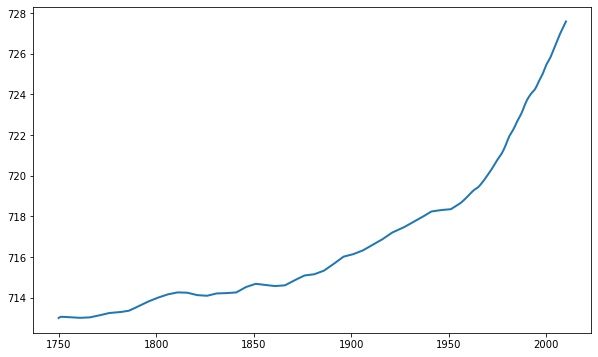

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,6))

fs = 16

#Plot as GtC:
ax1.plot(T, Y[:, 1] * 12 / 1e15, linewidth=2, label='Atm CO2 (GtC)')
#ax1.plot(T, Y[:, 2] * 12 / 1e15, linewidth=2, label='Upper Ocean CO2 (GtC)')

C:\Users\steff\AppData\Local\Temp/ipykernel_2384/1164008943.py:3: RuntimeWarning: divide by zero encountered in log10
  pH = -np.log10(H_track * 1000 / 18)


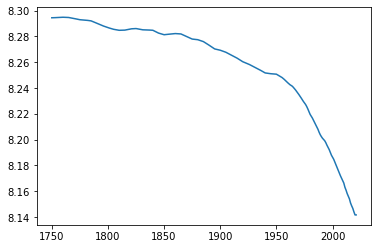

In [ ]:
#Also plot the pH
#H_track in mole fraction, so convert to Molarity
pH = -np.log10(H_track * 1000 / 18)

plt.plot(pH)